The goal of this figure is to show zonal-mean-zonal wind impacts in time-latitude space. This view will allow us to see latitudes and times of the most significant volcanic impacts for fixed pressure levels. The latitude domain stretches from pole to pole, and the time domain covers the first 3 years post-eruption.

In [3]:
import sys
import pdb
import numpy as np
import xarray as xr
import cmasher as cmr
import nclcmaps as ncm
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil

In [46]:
# ----- define pressure levels to plot, in hPa
pp   = [1, 10, 30, 100]
nlev = len(pp)

# ----- get U data
udir = putil.get_daily_variable('U', skip_nosrctag=True)

# ----- extract data at pressure levels
u        = udir['ensmean'].sel(plev=pp, method='nearest')
u_cf     = udir['cfmean'].sel(plev=pp, method='nearest')
u_impact = udir['impact'].sel(plev=pp, method='nearest')
u_pval   = udir['pval'].sel(plev=pp, method='nearest')
u_coh   = udir['coherence'].sel(plev=pp, method='nearest')

# ----- nan insignificant values
u_impact_filtered = u_impact.where(u_pval < 0.05)#, other=0)
upp = u_pval.where(u_impact > 0)
upn = u_pval.where(u_impact < 0)
#u_impact_filtered = u_impact.where(u_coh > 0.8)#, other=0)

# ----- get dims
time, lat, plev = u.time, u.lat, u.plev
plev = sorted(plev.values)
time = [datetime(t.year,t.month,t.day) for t in time.values]

# ----- set lat, time limits
latlim  = [-80, 80]
timelim = [time[0], datetime(time[0].year+2,time[0].month,time[0].day)]

getting data for variable U...


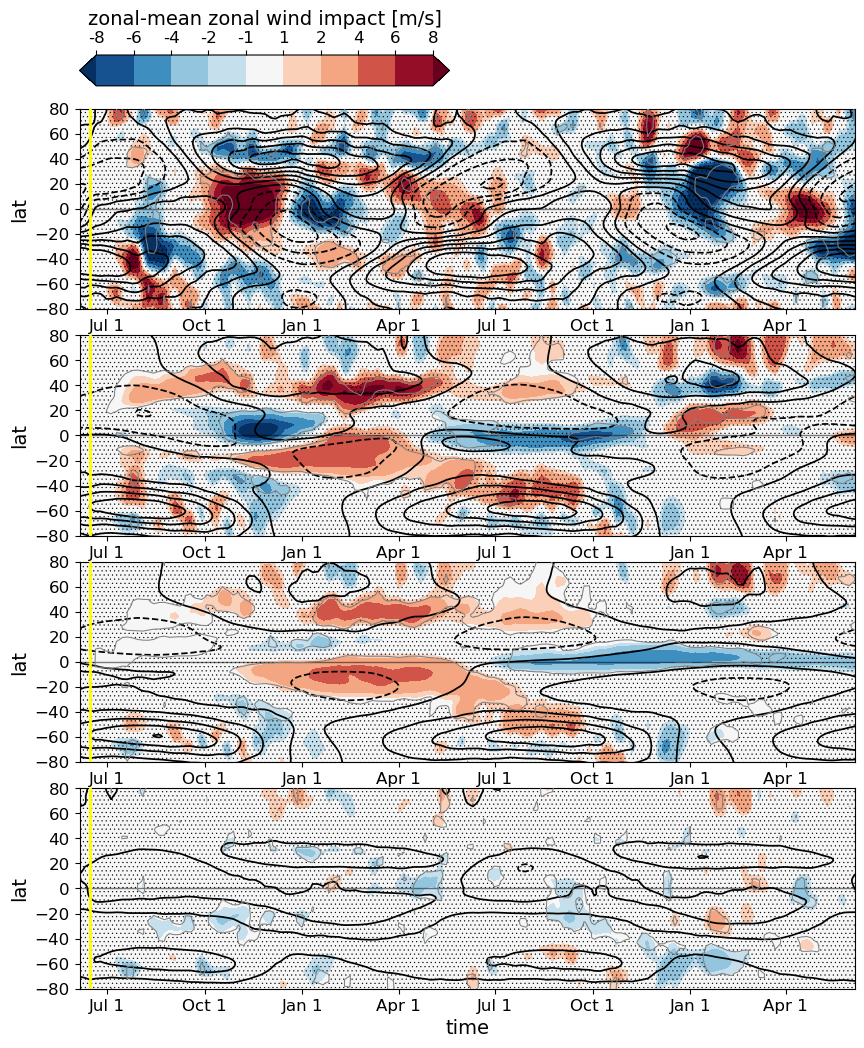

In [47]:
# ----- make figure, with vertically stacked axes per each pressure level
fig_width = 10
fig = plt.figure(figsize=(fig_width, (fig_width/3.5)*nlev))
ax = []
for i in range(nlev):
    ax.append(fig.add_subplot(nlev, 1, i+1))
    
# ----- ploting settings
cmap   = 'Greys'  # data colormap
zcolor = 'w'      # data zero-line color
zlw    = 0.66     # data zero-line linewidth
icmap  = 'RdBu_r' # impact colormap
ilw    = 1      # impact linewidth
ils    = '--'     # impact linestyle
ilwsig = 2.5      # impact significant linewidth
    
# ----- configure levels
lev   = np.arange(-60, 76, 15)
#ilev = [-10, -8, -6, -4, -2, -1, 1, 2, 4, 6, 8, 10]
ilev=[-8, -6, -4, -2.3, -1.5, 1.5, 2.3, 4, 6, 8]
inorm = putil.get_cmap_norm(ilev, 'twoslope')
    
# ----- plot data
for i in range(len(plev)):
    p = plev[i]
    
    # --- ensemble data
    ax[i].contour(time, lat, u_cf.sel(plev=p), colors='k', levels=lev, extend='both', linewidths=1.25)
    #ax[i].contour(time, lat, u_cf.sel(plev=p), colors='k', levels=lev, extend='both', linewidths=1.25, zorder=200, alpha=0.33)
    #ax[i].contour(time, lat, u_cf.sel(plev=p), colors=zcolor, linewidths=zlw, levels=[0]) # zero line
    
    # --- equator
    ax[i].axhline(y=0, color='k', ls='-', lw=1, alpha=0.5, zorder=100)
    # --- eruption
    ax[i].axvline(x=datetime(1991, 6, 15), color='yellow', ls='-', lw=2, zorder=100)
    
    # --- impact data
    cfui = ax[i].contourf(time, lat, u_impact.sel(plev=p), cmap=icmap, levels=ilev, norm=inorm, extend='both')#, linewidths=ilw, linestyles=ils)
    #ax[i].contour(time, lat, u_impact_filtered.sel(plev=p), cmap=icmap, 
    #                     levels=ilev, norm=inorm, linewidths=ilwsig)
    # dummy plot for impact colorbar
    #cfui = ax[i].contourf(time, lat, u_impact_filtered.sel(plev=p), cmap=icmap, levels=ilev, norm=inorm, extend='both', zorder=99)
    
    
    # --- pval
    mpl.rcParams['hatch.linewidth'] = 0.33
    ax[i].contour(time, lat, u_pval.sel(plev=p), colors='grey', levels=[0.05], linewidths=0.75, zorder=102)
    #ax[i].contour(time, lat, upp.sel(plev=p), colors='r', levels=[0.05], linewidths=1.75, zorder=102)
    #ax[i].contour(time, lat, upn.sel(plev=p), colors='b', levels=[0.05], linewidths=1.75, zorder=102)
    ax[i].contourf(time, lat, u_pval.sel(plev=p), levels=[0.05, u_pval.sel(plev=p).max()], 
                   hatches=['....'], colors='w', alpha=0)
    #ax[i].contour(time, lat, u_coh.sel(plev=p), colors='k', levels=[0.66], linewidths=0.75)
    #ax[i].contourf(time, lat, u_coh.sel(plev=p), levels=[0, 0.66], 
    #               hatches=[''], colors='w', alpha=0.5)
    
# ----- make colorbars

# - impact
#icbar = fig.colorbar(cfui, cax=fig.add_axes([0.93, 0.11, 0.02, 0.37]))
icbar = fig.colorbar(cfui, cax=fig.add_axes([0.125, 0.9, 0.37, 0.027]), 
                     orientation='horizontal', location='top')
icbar.solids.set_alpha(1)
icbar.set_label('zonal-mean zonal wind impact [m/s]')
icbar.set_ticklabels(np.array(ilev).astype(int))

# ----- format
for axi in ax:
    putil.season_timeticks(axi.xaxis, time, 'season')
    axi.set_ylabel('lat')
ax[-1].set_xlabel('time')
    
# ----- set axis ticks, limits
for axi in ax:
    axi.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
    axi.set_ylim(latlim)
    axi.set_xlim(timelim)
ax[-1].set_xlabel('time')

plt.subplots_adjust(hspace=0.13)

# ---- overlay latbands and times for reference
if(0):
    for axi in ax:
        axi.fill_between(x=time, y1=50, y2=30, color='cyan', interpolate=True, alpha=.33)
        axi.fill_between(x=time, y1=5, y2=-5, color='cyan', interpolate=True, alpha=.33)
        axi.fill_between(x=time, y1=-30, y2=-50, color='cyan', interpolate=True, alpha=.5)
        #axi.axvspan(datetime(1991,8,15), datetime(1991,11,15), alpha=0.5, color='cyan')
        #axi.axvspan(datetime(1992,7,15), datetime(1992,9,1), alpha=0.5, color='cyan')

#plt.savefig('figs/lat_time_uimpact.png', dpi=200)
plt.show()